# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

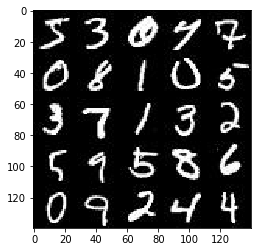

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

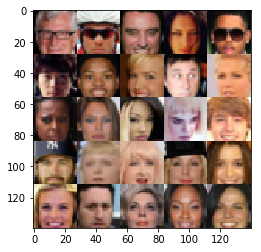

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):

        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        reul1 = tf.maximum(alpha * x1, x1)
        drop1 = tf.nn.dropout(x1, 0.9)
        
        x2 = tf.layers.conv2d(drop1, 128, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        drop2 = tf.nn.dropout(relu2, 0.9)
        
        x3 = tf.layers.conv2d(drop2, 256, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        drop3 = tf.nn.dropout(relu3, 0.9)

        flat = tf.reshape(drop3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        
        x1 = tf.layers.dense(z, 7*7*512)

        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, 0.5)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, 0.5)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, 0.5)

        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
       
        out = tf.tanh(logits) 
   
    return out
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                         labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                         labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                    labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    images_count, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):

                steps += 1
                batch_images *= 2

                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.6533... Generator Loss: 3.9313
Epoch 1/2... Discriminator Loss: 0.3921... Generator Loss: 4.9085
Epoch 1/2... Discriminator Loss: 2.0185... Generator Loss: 0.4775
Epoch 1/2... Discriminator Loss: 0.6807... Generator Loss: 2.4959
Epoch 1/2... Discriminator Loss: 0.5788... Generator Loss: 2.3130
Epoch 1/2... Discriminator Loss: 0.4302... Generator Loss: 3.5372
Epoch 1/2... Discriminator Loss: 0.5082... Generator Loss: 3.1701
Epoch 1/2... Discriminator Loss: 1.0275... Generator Loss: 1.1666
Epoch 1/2... Discriminator Loss: 1.2439... Generator Loss: 2.5757
Epoch 1/2... Discriminator Loss: 0.8626... Generator Loss: 1.5757


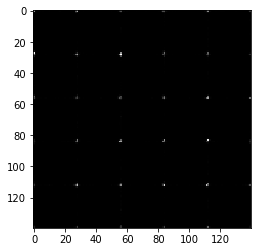

Epoch 1/2... Discriminator Loss: 1.3057... Generator Loss: 0.5518
Epoch 1/2... Discriminator Loss: 1.0214... Generator Loss: 1.4379
Epoch 1/2... Discriminator Loss: 0.7862... Generator Loss: 1.9664
Epoch 1/2... Discriminator Loss: 1.3601... Generator Loss: 2.6829
Epoch 1/2... Discriminator Loss: 0.8136... Generator Loss: 2.2888
Epoch 1/2... Discriminator Loss: 1.0427... Generator Loss: 1.7173
Epoch 1/2... Discriminator Loss: 0.8981... Generator Loss: 1.7356
Epoch 1/2... Discriminator Loss: 0.7327... Generator Loss: 1.9510
Epoch 1/2... Discriminator Loss: 0.7961... Generator Loss: 2.0817
Epoch 1/2... Discriminator Loss: 0.9193... Generator Loss: 3.4205


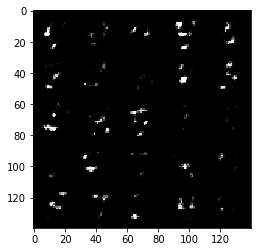

Epoch 1/2... Discriminator Loss: 0.7052... Generator Loss: 1.8662
Epoch 1/2... Discriminator Loss: 1.1893... Generator Loss: 0.7074
Epoch 1/2... Discriminator Loss: 1.2706... Generator Loss: 2.5302
Epoch 1/2... Discriminator Loss: 0.9390... Generator Loss: 1.0358
Epoch 1/2... Discriminator Loss: 0.6698... Generator Loss: 1.9061
Epoch 1/2... Discriminator Loss: 1.2843... Generator Loss: 2.6902
Epoch 1/2... Discriminator Loss: 1.1326... Generator Loss: 1.9662
Epoch 1/2... Discriminator Loss: 1.5112... Generator Loss: 0.6501
Epoch 1/2... Discriminator Loss: 1.7201... Generator Loss: 1.7337
Epoch 1/2... Discriminator Loss: 1.1879... Generator Loss: 0.8812


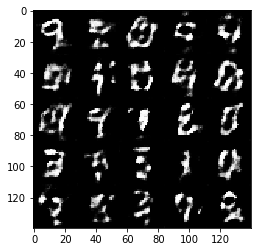

Epoch 1/2... Discriminator Loss: 1.1896... Generator Loss: 1.0388
Epoch 1/2... Discriminator Loss: 1.0756... Generator Loss: 1.0695
Epoch 1/2... Discriminator Loss: 1.1061... Generator Loss: 1.1703
Epoch 1/2... Discriminator Loss: 1.1858... Generator Loss: 1.3669
Epoch 1/2... Discriminator Loss: 1.1434... Generator Loss: 1.2225
Epoch 1/2... Discriminator Loss: 1.1803... Generator Loss: 1.8580
Epoch 1/2... Discriminator Loss: 1.0168... Generator Loss: 1.2107
Epoch 1/2... Discriminator Loss: 0.9958... Generator Loss: 1.4379
Epoch 1/2... Discriminator Loss: 1.1513... Generator Loss: 1.2946
Epoch 1/2... Discriminator Loss: 1.1606... Generator Loss: 1.1429


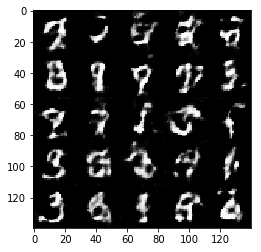

Epoch 1/2... Discriminator Loss: 1.1144... Generator Loss: 1.6263
Epoch 1/2... Discriminator Loss: 0.9286... Generator Loss: 1.4169
Epoch 1/2... Discriminator Loss: 0.9413... Generator Loss: 1.3881
Epoch 1/2... Discriminator Loss: 0.9422... Generator Loss: 1.2096
Epoch 1/2... Discriminator Loss: 1.0161... Generator Loss: 1.4129
Epoch 1/2... Discriminator Loss: 1.0208... Generator Loss: 1.0868
Epoch 1/2... Discriminator Loss: 0.9916... Generator Loss: 1.0925
Epoch 1/2... Discriminator Loss: 0.9865... Generator Loss: 1.0956
Epoch 1/2... Discriminator Loss: 0.9891... Generator Loss: 1.6119
Epoch 1/2... Discriminator Loss: 1.0659... Generator Loss: 0.9308


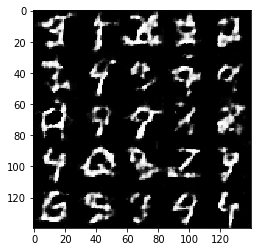

Epoch 1/2... Discriminator Loss: 1.1735... Generator Loss: 1.1136
Epoch 1/2... Discriminator Loss: 0.9395... Generator Loss: 1.2268
Epoch 1/2... Discriminator Loss: 1.0120... Generator Loss: 1.3898
Epoch 1/2... Discriminator Loss: 0.9241... Generator Loss: 1.2890
Epoch 1/2... Discriminator Loss: 1.0473... Generator Loss: 1.2263
Epoch 1/2... Discriminator Loss: 1.1370... Generator Loss: 1.3724
Epoch 1/2... Discriminator Loss: 1.2282... Generator Loss: 0.8370
Epoch 1/2... Discriminator Loss: 0.9843... Generator Loss: 1.5526
Epoch 1/2... Discriminator Loss: 1.2987... Generator Loss: 0.7448
Epoch 1/2... Discriminator Loss: 1.0011... Generator Loss: 1.5319


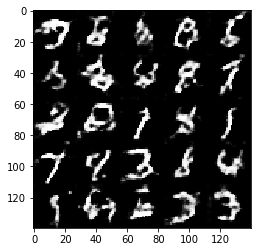

Epoch 1/2... Discriminator Loss: 1.0379... Generator Loss: 1.2616
Epoch 1/2... Discriminator Loss: 0.9470... Generator Loss: 1.2970
Epoch 1/2... Discriminator Loss: 0.9553... Generator Loss: 1.3941
Epoch 1/2... Discriminator Loss: 1.1104... Generator Loss: 0.9998
Epoch 1/2... Discriminator Loss: 1.1230... Generator Loss: 1.0173
Epoch 1/2... Discriminator Loss: 1.0904... Generator Loss: 0.9969
Epoch 1/2... Discriminator Loss: 1.1205... Generator Loss: 2.0487
Epoch 1/2... Discriminator Loss: 1.1899... Generator Loss: 0.9884
Epoch 1/2... Discriminator Loss: 1.0195... Generator Loss: 1.1091
Epoch 1/2... Discriminator Loss: 1.1081... Generator Loss: 1.3300


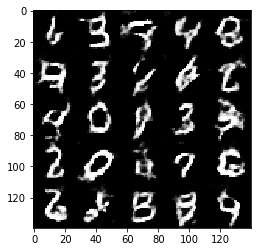

Epoch 1/2... Discriminator Loss: 1.0117... Generator Loss: 1.2184
Epoch 1/2... Discriminator Loss: 1.0375... Generator Loss: 1.4633
Epoch 1/2... Discriminator Loss: 1.0124... Generator Loss: 1.2597
Epoch 1/2... Discriminator Loss: 1.0261... Generator Loss: 1.8553
Epoch 1/2... Discriminator Loss: 0.9243... Generator Loss: 1.1792
Epoch 1/2... Discriminator Loss: 1.1491... Generator Loss: 0.9460
Epoch 1/2... Discriminator Loss: 0.9841... Generator Loss: 1.8483
Epoch 1/2... Discriminator Loss: 0.9951... Generator Loss: 1.2183
Epoch 1/2... Discriminator Loss: 1.0235... Generator Loss: 1.0077
Epoch 1/2... Discriminator Loss: 1.0879... Generator Loss: 0.9511


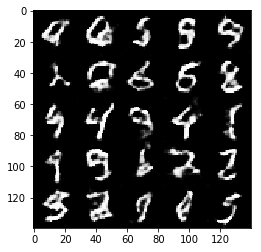

Epoch 1/2... Discriminator Loss: 0.9949... Generator Loss: 1.5026
Epoch 1/2... Discriminator Loss: 0.9459... Generator Loss: 1.3827
Epoch 1/2... Discriminator Loss: 0.9771... Generator Loss: 1.8037
Epoch 1/2... Discriminator Loss: 0.7903... Generator Loss: 1.9735
Epoch 1/2... Discriminator Loss: 0.9299... Generator Loss: 1.8486
Epoch 1/2... Discriminator Loss: 1.0747... Generator Loss: 1.2852
Epoch 1/2... Discriminator Loss: 1.1719... Generator Loss: 1.0318
Epoch 1/2... Discriminator Loss: 0.9689... Generator Loss: 1.1082
Epoch 1/2... Discriminator Loss: 0.9821... Generator Loss: 1.1766
Epoch 1/2... Discriminator Loss: 0.9275... Generator Loss: 1.6542


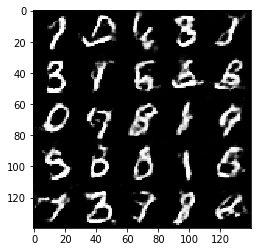

Epoch 1/2... Discriminator Loss: 0.9294... Generator Loss: 1.2031
Epoch 1/2... Discriminator Loss: 0.9655... Generator Loss: 1.1493
Epoch 1/2... Discriminator Loss: 1.1507... Generator Loss: 0.9088
Epoch 2/2... Discriminator Loss: 0.9294... Generator Loss: 1.6170
Epoch 2/2... Discriminator Loss: 0.9553... Generator Loss: 1.0340
Epoch 2/2... Discriminator Loss: 1.0572... Generator Loss: 1.0934
Epoch 2/2... Discriminator Loss: 1.0975... Generator Loss: 1.0950
Epoch 2/2... Discriminator Loss: 1.0201... Generator Loss: 1.1786
Epoch 2/2... Discriminator Loss: 0.8817... Generator Loss: 1.3641
Epoch 2/2... Discriminator Loss: 0.9767... Generator Loss: 1.4396


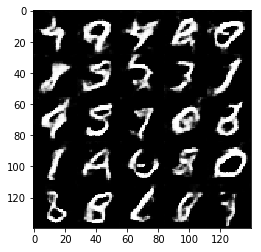

Epoch 2/2... Discriminator Loss: 0.8847... Generator Loss: 1.4415
Epoch 2/2... Discriminator Loss: 0.8626... Generator Loss: 1.7676
Epoch 2/2... Discriminator Loss: 0.8796... Generator Loss: 1.0756
Epoch 2/2... Discriminator Loss: 0.9387... Generator Loss: 1.1066
Epoch 2/2... Discriminator Loss: 0.9028... Generator Loss: 1.3005
Epoch 2/2... Discriminator Loss: 1.0341... Generator Loss: 1.1655
Epoch 2/2... Discriminator Loss: 1.0620... Generator Loss: 1.5679
Epoch 2/2... Discriminator Loss: 1.1504... Generator Loss: 0.8572
Epoch 2/2... Discriminator Loss: 1.0129... Generator Loss: 1.3805
Epoch 2/2... Discriminator Loss: 1.0732... Generator Loss: 1.0216


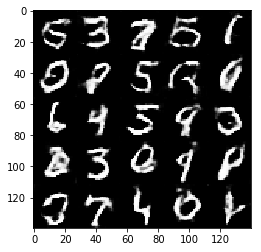

Epoch 2/2... Discriminator Loss: 0.8856... Generator Loss: 1.1268
Epoch 2/2... Discriminator Loss: 0.9146... Generator Loss: 1.8327
Epoch 2/2... Discriminator Loss: 0.9128... Generator Loss: 1.4616
Epoch 2/2... Discriminator Loss: 0.9822... Generator Loss: 1.0123
Epoch 2/2... Discriminator Loss: 1.0460... Generator Loss: 1.0618
Epoch 2/2... Discriminator Loss: 0.9510... Generator Loss: 0.9684
Epoch 2/2... Discriminator Loss: 1.0239... Generator Loss: 1.4450
Epoch 2/2... Discriminator Loss: 0.9337... Generator Loss: 1.2940
Epoch 2/2... Discriminator Loss: 0.9497... Generator Loss: 1.1445
Epoch 2/2... Discriminator Loss: 0.9630... Generator Loss: 1.5364


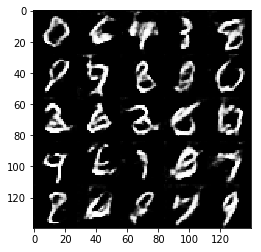

Epoch 2/2... Discriminator Loss: 1.0307... Generator Loss: 1.9886
Epoch 2/2... Discriminator Loss: 1.0661... Generator Loss: 1.6772
Epoch 2/2... Discriminator Loss: 0.8976... Generator Loss: 1.2568
Epoch 2/2... Discriminator Loss: 1.0732... Generator Loss: 1.6129
Epoch 2/2... Discriminator Loss: 0.9272... Generator Loss: 1.6588
Epoch 2/2... Discriminator Loss: 0.9084... Generator Loss: 1.4182
Epoch 2/2... Discriminator Loss: 1.1748... Generator Loss: 0.7514
Epoch 2/2... Discriminator Loss: 1.2162... Generator Loss: 0.8419
Epoch 2/2... Discriminator Loss: 1.0670... Generator Loss: 1.8608
Epoch 2/2... Discriminator Loss: 1.0443... Generator Loss: 1.6075


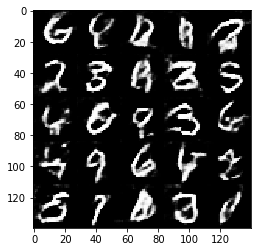

Epoch 2/2... Discriminator Loss: 0.9019... Generator Loss: 1.2462
Epoch 2/2... Discriminator Loss: 1.2153... Generator Loss: 1.0182
Epoch 2/2... Discriminator Loss: 1.0284... Generator Loss: 1.7027
Epoch 2/2... Discriminator Loss: 0.9809... Generator Loss: 1.1621
Epoch 2/2... Discriminator Loss: 1.0598... Generator Loss: 1.0914
Epoch 2/2... Discriminator Loss: 0.9824... Generator Loss: 1.2194
Epoch 2/2... Discriminator Loss: 0.9029... Generator Loss: 1.5753
Epoch 2/2... Discriminator Loss: 0.8622... Generator Loss: 1.3254
Epoch 2/2... Discriminator Loss: 1.0286... Generator Loss: 1.8226
Epoch 2/2... Discriminator Loss: 1.0187... Generator Loss: 1.9486


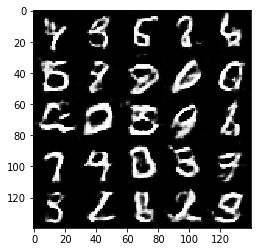

Epoch 2/2... Discriminator Loss: 1.0905... Generator Loss: 0.8214
Epoch 2/2... Discriminator Loss: 1.0193... Generator Loss: 1.4571
Epoch 2/2... Discriminator Loss: 1.1270... Generator Loss: 0.9137
Epoch 2/2... Discriminator Loss: 0.8510... Generator Loss: 1.3647
Epoch 2/2... Discriminator Loss: 0.8593... Generator Loss: 1.2320
Epoch 2/2... Discriminator Loss: 0.9198... Generator Loss: 1.6480
Epoch 2/2... Discriminator Loss: 0.9763... Generator Loss: 1.3944
Epoch 2/2... Discriminator Loss: 0.9510... Generator Loss: 1.3051
Epoch 2/2... Discriminator Loss: 1.0518... Generator Loss: 1.0597
Epoch 2/2... Discriminator Loss: 0.9509... Generator Loss: 1.5945


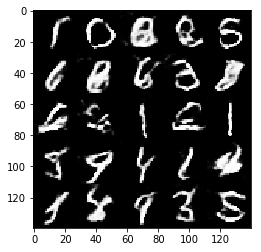

Epoch 2/2... Discriminator Loss: 0.9437... Generator Loss: 1.2034
Epoch 2/2... Discriminator Loss: 0.8870... Generator Loss: 1.2166
Epoch 2/2... Discriminator Loss: 0.8973... Generator Loss: 1.6142
Epoch 2/2... Discriminator Loss: 0.9653... Generator Loss: 1.2941
Epoch 2/2... Discriminator Loss: 0.7998... Generator Loss: 1.5737
Epoch 2/2... Discriminator Loss: 0.9468... Generator Loss: 1.6276
Epoch 2/2... Discriminator Loss: 1.1357... Generator Loss: 1.7715
Epoch 2/2... Discriminator Loss: 0.8890... Generator Loss: 1.3520
Epoch 2/2... Discriminator Loss: 1.1424... Generator Loss: 1.0375
Epoch 2/2... Discriminator Loss: 0.9237... Generator Loss: 1.4309


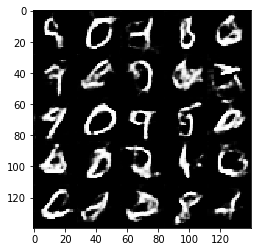

Epoch 2/2... Discriminator Loss: 0.9654... Generator Loss: 1.3696
Epoch 2/2... Discriminator Loss: 0.9672... Generator Loss: 1.2753
Epoch 2/2... Discriminator Loss: 0.9443... Generator Loss: 1.2735
Epoch 2/2... Discriminator Loss: 0.9611... Generator Loss: 1.3533
Epoch 2/2... Discriminator Loss: 1.1185... Generator Loss: 1.0701
Epoch 2/2... Discriminator Loss: 0.9807... Generator Loss: 1.5287
Epoch 2/2... Discriminator Loss: 0.9360... Generator Loss: 1.6673
Epoch 2/2... Discriminator Loss: 0.8989... Generator Loss: 1.1647
Epoch 2/2... Discriminator Loss: 0.8509... Generator Loss: 1.3079
Epoch 2/2... Discriminator Loss: 1.1370... Generator Loss: 0.9216


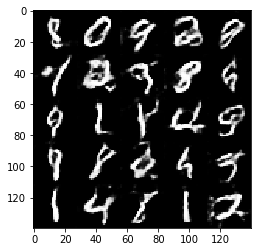

Epoch 2/2... Discriminator Loss: 0.8705... Generator Loss: 1.5104
Epoch 2/2... Discriminator Loss: 1.0102... Generator Loss: 1.8063
Epoch 2/2... Discriminator Loss: 1.1490... Generator Loss: 0.8747
Epoch 2/2... Discriminator Loss: 1.1349... Generator Loss: 2.1776
Epoch 2/2... Discriminator Loss: 0.8971... Generator Loss: 1.7239
Epoch 2/2... Discriminator Loss: 0.9289... Generator Loss: 1.7982
Epoch 2/2... Discriminator Loss: 0.8887... Generator Loss: 1.1086
Epoch 2/2... Discriminator Loss: 0.8818... Generator Loss: 1.4719
Epoch 2/2... Discriminator Loss: 0.6761... Generator Loss: 2.0679
Epoch 2/2... Discriminator Loss: 1.0780... Generator Loss: 1.4209


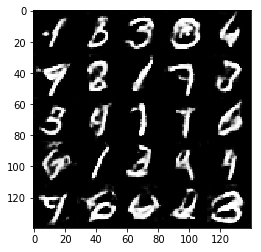

Epoch 2/2... Discriminator Loss: 0.8632... Generator Loss: 1.2171
Epoch 2/2... Discriminator Loss: 0.9551... Generator Loss: 1.0690
Epoch 2/2... Discriminator Loss: 0.8274... Generator Loss: 1.7732
Epoch 2/2... Discriminator Loss: 0.9125... Generator Loss: 1.3516
Epoch 2/2... Discriminator Loss: 0.9846... Generator Loss: 1.5759
Epoch 2/2... Discriminator Loss: 1.0189... Generator Loss: 1.7684
Epoch 2/2... Discriminator Loss: 0.8746... Generator Loss: 1.1545


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.3471... Generator Loss: 1.1812
Epoch 1/1... Discriminator Loss: 4.3254... Generator Loss: 7.1495
Epoch 1/1... Discriminator Loss: 1.0563... Generator Loss: 2.0583
Epoch 1/1... Discriminator Loss: 0.6815... Generator Loss: 2.7724
Epoch 1/1... Discriminator Loss: 1.3087... Generator Loss: 5.2228
Epoch 1/1... Discriminator Loss: 0.7333... Generator Loss: 5.1215
Epoch 1/1... Discriminator Loss: 1.0421... Generator Loss: 2.5097
Epoch 1/1... Discriminator Loss: 0.5928... Generator Loss: 2.1848
Epoch 1/1... Discriminator Loss: 0.5021... Generator Loss: 3.1226
Epoch 1/1... Discriminator Loss: 0.6936... Generator Loss: 4.7194


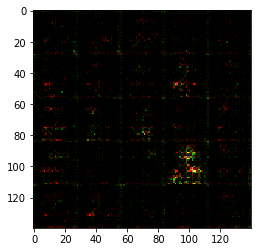

Epoch 1/1... Discriminator Loss: 0.4345... Generator Loss: 3.3085
Epoch 1/1... Discriminator Loss: 0.4849... Generator Loss: 2.5174
Epoch 1/1... Discriminator Loss: 0.3769... Generator Loss: 4.6339
Epoch 1/1... Discriminator Loss: 0.3793... Generator Loss: 3.5842
Epoch 1/1... Discriminator Loss: 0.3829... Generator Loss: 4.6178
Epoch 1/1... Discriminator Loss: 0.3626... Generator Loss: 4.8167
Epoch 1/1... Discriminator Loss: 0.4986... Generator Loss: 3.7365
Epoch 1/1... Discriminator Loss: 0.3689... Generator Loss: 4.3101
Epoch 1/1... Discriminator Loss: 3.2041... Generator Loss: 3.6268
Epoch 1/1... Discriminator Loss: 1.1473... Generator Loss: 1.0336


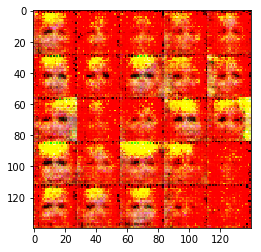

Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 0.7815... Generator Loss: 1.2832
Epoch 1/1... Discriminator Loss: 0.8335... Generator Loss: 1.2100
Epoch 1/1... Discriminator Loss: 2.6539... Generator Loss: 6.4487
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.8437
Epoch 1/1... Discriminator Loss: 2.2246... Generator Loss: 3.8586
Epoch 1/1... Discriminator Loss: 0.7703... Generator Loss: 2.0736
Epoch 1/1... Discriminator Loss: 1.1975... Generator Loss: 0.7200
Epoch 1/1... Discriminator Loss: 0.6639... Generator Loss: 1.6722
Epoch 1/1... Discriminator Loss: 0.7543... Generator Loss: 1.5833


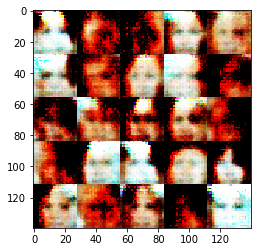

Epoch 1/1... Discriminator Loss: 1.2854... Generator Loss: 0.8397
Epoch 1/1... Discriminator Loss: 1.1338... Generator Loss: 2.7818
Epoch 1/1... Discriminator Loss: 1.1151... Generator Loss: 2.1262
Epoch 1/1... Discriminator Loss: 0.9905... Generator Loss: 1.3145
Epoch 1/1... Discriminator Loss: 1.4724... Generator Loss: 1.9542
Epoch 1/1... Discriminator Loss: 0.9103... Generator Loss: 1.2485
Epoch 1/1... Discriminator Loss: 0.8781... Generator Loss: 1.2802
Epoch 1/1... Discriminator Loss: 1.1388... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.0779... Generator Loss: 1.6295
Epoch 1/1... Discriminator Loss: 1.1431... Generator Loss: 1.3692


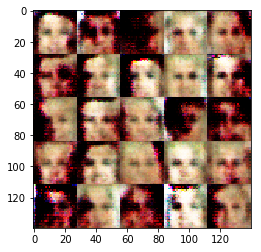

Epoch 1/1... Discriminator Loss: 3.7526... Generator Loss: 4.6209
Epoch 1/1... Discriminator Loss: 0.9522... Generator Loss: 1.1739
Epoch 1/1... Discriminator Loss: 2.6388... Generator Loss: 3.6247
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.8430
Epoch 1/1... Discriminator Loss: 1.1275... Generator Loss: 1.1489
Epoch 1/1... Discriminator Loss: 1.0200... Generator Loss: 1.2060
Epoch 1/1... Discriminator Loss: 1.0781... Generator Loss: 0.9553
Epoch 1/1... Discriminator Loss: 1.0223... Generator Loss: 1.4785
Epoch 1/1... Discriminator Loss: 1.0852... Generator Loss: 1.0746
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.5366


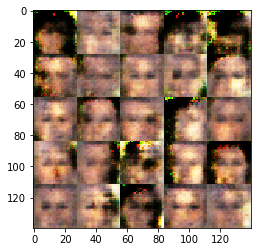

Epoch 1/1... Discriminator Loss: 2.0746... Generator Loss: 3.1402
Epoch 1/1... Discriminator Loss: 1.1148... Generator Loss: 2.4089
Epoch 1/1... Discriminator Loss: 1.1138... Generator Loss: 0.8314
Epoch 1/1... Discriminator Loss: 3.2064... Generator Loss: 4.2655
Epoch 1/1... Discriminator Loss: 1.0677... Generator Loss: 0.9401
Epoch 1/1... Discriminator Loss: 1.0006... Generator Loss: 1.3106
Epoch 1/1... Discriminator Loss: 1.9296... Generator Loss: 3.0690
Epoch 1/1... Discriminator Loss: 2.2550... Generator Loss: 0.1953
Epoch 1/1... Discriminator Loss: 1.1989... Generator Loss: 0.8396
Epoch 1/1... Discriminator Loss: 1.1248... Generator Loss: 1.0834


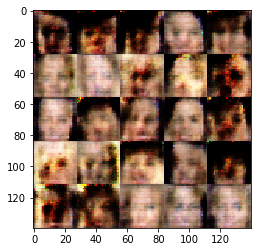

Epoch 1/1... Discriminator Loss: 1.0629... Generator Loss: 0.8811
Epoch 1/1... Discriminator Loss: 1.1910... Generator Loss: 1.3821
Epoch 1/1... Discriminator Loss: 1.0348... Generator Loss: 0.9102
Epoch 1/1... Discriminator Loss: 1.1615... Generator Loss: 0.9466
Epoch 1/1... Discriminator Loss: 1.2126... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 1.0918... Generator Loss: 1.1543
Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 2.1279... Generator Loss: 2.7865
Epoch 1/1... Discriminator Loss: 0.9868... Generator Loss: 1.1527
Epoch 1/1... Discriminator Loss: 1.2373... Generator Loss: 1.0086


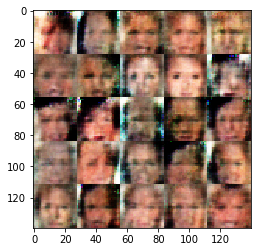

Epoch 1/1... Discriminator Loss: 0.9438... Generator Loss: 1.1751
Epoch 1/1... Discriminator Loss: 1.2553... Generator Loss: 0.7792
Epoch 1/1... Discriminator Loss: 1.4913... Generator Loss: 0.5590
Epoch 1/1... Discriminator Loss: 1.1111... Generator Loss: 1.1943
Epoch 1/1... Discriminator Loss: 1.2808... Generator Loss: 1.1729
Epoch 1/1... Discriminator Loss: 1.2999... Generator Loss: 0.9097
Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 1.6100
Epoch 1/1... Discriminator Loss: 1.0324... Generator Loss: 1.2011
Epoch 1/1... Discriminator Loss: 1.5699... Generator Loss: 2.1066
Epoch 1/1... Discriminator Loss: 1.0837... Generator Loss: 1.0095


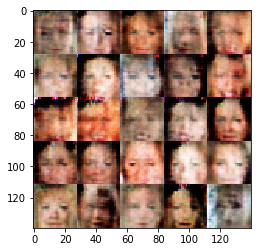

Epoch 1/1... Discriminator Loss: 1.2068... Generator Loss: 1.2691
Epoch 1/1... Discriminator Loss: 1.2233... Generator Loss: 1.2294
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 1.8776
Epoch 1/1... Discriminator Loss: 1.2109... Generator Loss: 0.9125
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 1.1654... Generator Loss: 1.0221
Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 0.9691
Epoch 1/1... Discriminator Loss: 1.2159... Generator Loss: 0.9940
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 1.6802
Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 1.2477


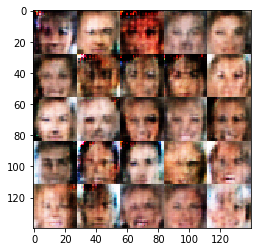

Epoch 1/1... Discriminator Loss: 1.2087... Generator Loss: 0.8744
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 1.6026
Epoch 1/1... Discriminator Loss: 1.2687... Generator Loss: 1.0250
Epoch 1/1... Discriminator Loss: 1.1920... Generator Loss: 0.9853
Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 1.0363
Epoch 1/1... Discriminator Loss: 1.5259... Generator Loss: 1.5068
Epoch 1/1... Discriminator Loss: 1.5071... Generator Loss: 0.4316
Epoch 1/1... Discriminator Loss: 1.4457... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.5112... Generator Loss: 0.4743
Epoch 1/1... Discriminator Loss: 1.0565... Generator Loss: 1.3217


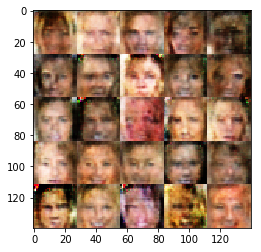

Epoch 1/1... Discriminator Loss: 1.2713... Generator Loss: 0.7686
Epoch 1/1... Discriminator Loss: 1.1976... Generator Loss: 2.0571
Epoch 1/1... Discriminator Loss: 1.2868... Generator Loss: 1.2689
Epoch 1/1... Discriminator Loss: 1.3271... Generator Loss: 1.5366
Epoch 1/1... Discriminator Loss: 1.4929... Generator Loss: 1.5174
Epoch 1/1... Discriminator Loss: 1.4828... Generator Loss: 0.5186
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 1.2400... Generator Loss: 1.7563
Epoch 1/1... Discriminator Loss: 1.4899... Generator Loss: 1.4033
Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 0.6471


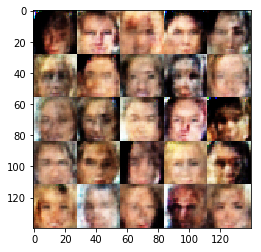

Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 0.7293
Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 1.0882
Epoch 1/1... Discriminator Loss: 1.3343... Generator Loss: 1.0927
Epoch 1/1... Discriminator Loss: 1.0604... Generator Loss: 1.3267
Epoch 1/1... Discriminator Loss: 1.2756... Generator Loss: 1.0180
Epoch 1/1... Discriminator Loss: 1.1131... Generator Loss: 1.1436
Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 0.9495
Epoch 1/1... Discriminator Loss: 1.1614... Generator Loss: 0.9966
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.6615
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 1.3600


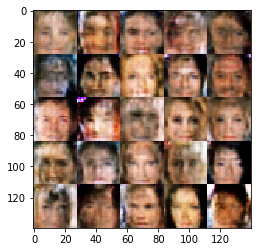

Epoch 1/1... Discriminator Loss: 1.2825... Generator Loss: 0.8404
Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 1.1182
Epoch 1/1... Discriminator Loss: 1.2135... Generator Loss: 0.9539
Epoch 1/1... Discriminator Loss: 1.2594... Generator Loss: 1.2212
Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 1.3053
Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.5149
Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 0.9157
Epoch 1/1... Discriminator Loss: 1.1563... Generator Loss: 1.2554
Epoch 1/1... Discriminator Loss: 1.7584... Generator Loss: 1.5123
Epoch 1/1... Discriminator Loss: 1.2948... Generator Loss: 1.0730


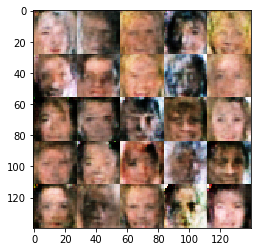

Epoch 1/1... Discriminator Loss: 1.2547... Generator Loss: 0.8708
Epoch 1/1... Discriminator Loss: 1.7530... Generator Loss: 0.3612
Epoch 1/1... Discriminator Loss: 1.0835... Generator Loss: 1.0646
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.8024
Epoch 1/1... Discriminator Loss: 1.2645... Generator Loss: 0.8347
Epoch 1/1... Discriminator Loss: 1.2873... Generator Loss: 0.8973
Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 0.9487
Epoch 1/1... Discriminator Loss: 1.1965... Generator Loss: 0.8434
Epoch 1/1... Discriminator Loss: 1.3140... Generator Loss: 0.9410
Epoch 1/1... Discriminator Loss: 1.8259... Generator Loss: 1.7022


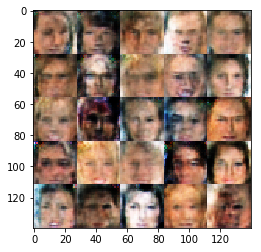

Epoch 1/1... Discriminator Loss: 1.1503... Generator Loss: 0.9478
Epoch 1/1... Discriminator Loss: 1.5548... Generator Loss: 0.4165
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 0.8536
Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 0.9471
Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 0.5977
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.6375
Epoch 1/1... Discriminator Loss: 1.2156... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 1.1810... Generator Loss: 1.0422
Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 0.8633
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 1.7843


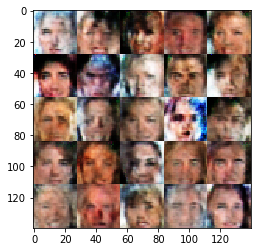

Epoch 1/1... Discriminator Loss: 1.3102... Generator Loss: 0.8629
Epoch 1/1... Discriminator Loss: 1.1543... Generator Loss: 1.1127
Epoch 1/1... Discriminator Loss: 1.2675... Generator Loss: 0.9882
Epoch 1/1... Discriminator Loss: 1.0688... Generator Loss: 1.2550
Epoch 1/1... Discriminator Loss: 1.2073... Generator Loss: 0.7142
Epoch 1/1... Discriminator Loss: 1.2157... Generator Loss: 0.9293
Epoch 1/1... Discriminator Loss: 1.1859... Generator Loss: 0.9726
Epoch 1/1... Discriminator Loss: 1.2720... Generator Loss: 0.9559
Epoch 1/1... Discriminator Loss: 1.3192... Generator Loss: 0.8581
Epoch 1/1... Discriminator Loss: 1.1513... Generator Loss: 1.1219


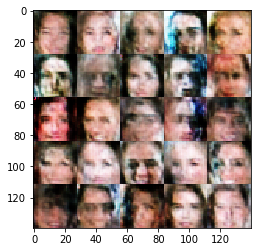

Epoch 1/1... Discriminator Loss: 1.2633... Generator Loss: 0.9678
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 0.7593
Epoch 1/1... Discriminator Loss: 1.3030... Generator Loss: 0.8736
Epoch 1/1... Discriminator Loss: 1.5169... Generator Loss: 1.3187
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.7560
Epoch 1/1... Discriminator Loss: 1.3137... Generator Loss: 0.7234
Epoch 1/1... Discriminator Loss: 1.2471... Generator Loss: 0.8574
Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.7327
Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.6668


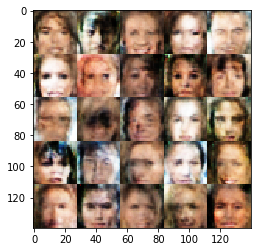

Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 0.6313
Epoch 1/1... Discriminator Loss: 1.2477... Generator Loss: 0.7171
Epoch 1/1... Discriminator Loss: 1.2529... Generator Loss: 1.0799
Epoch 1/1... Discriminator Loss: 1.1971... Generator Loss: 1.0288
Epoch 1/1... Discriminator Loss: 1.3067... Generator Loss: 0.8301
Epoch 1/1... Discriminator Loss: 1.2693... Generator Loss: 0.7025
Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 0.7437
Epoch 1/1... Discriminator Loss: 1.2993... Generator Loss: 0.8812
Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 1.2143


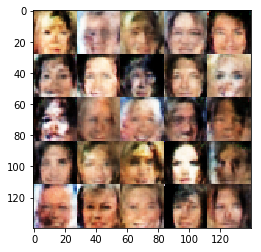

Epoch 1/1... Discriminator Loss: 1.1983... Generator Loss: 0.9734
Epoch 1/1... Discriminator Loss: 1.4825... Generator Loss: 1.3523
Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 0.9884
Epoch 1/1... Discriminator Loss: 1.2227... Generator Loss: 0.9543
Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 1.0784
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.9750
Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 1.0956
Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 0.9932
Epoch 1/1... Discriminator Loss: 1.1843... Generator Loss: 0.9710
Epoch 1/1... Discriminator Loss: 1.2829... Generator Loss: 0.9661


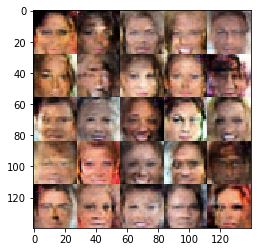

Epoch 1/1... Discriminator Loss: 1.1805... Generator Loss: 1.2643
Epoch 1/1... Discriminator Loss: 1.3230... Generator Loss: 1.2090
Epoch 1/1... Discriminator Loss: 1.2142... Generator Loss: 0.9299
Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 0.6307
Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 1.0144
Epoch 1/1... Discriminator Loss: 1.2425... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 1.3130... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 1.1124
Epoch 1/1... Discriminator Loss: 1.2974... Generator Loss: 0.8417
Epoch 1/1... Discriminator Loss: 1.2800... Generator Loss: 0.9329


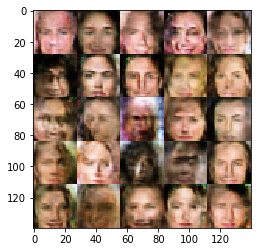

Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 1.0950
Epoch 1/1... Discriminator Loss: 1.1983... Generator Loss: 0.9450
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 1.0709
Epoch 1/1... Discriminator Loss: 1.1074... Generator Loss: 0.9200
Epoch 1/1... Discriminator Loss: 1.2529... Generator Loss: 0.8721
Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 0.9847
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.6417
Epoch 1/1... Discriminator Loss: 1.2386... Generator Loss: 0.9493


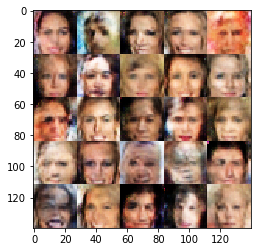

Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 0.9295
Epoch 1/1... Discriminator Loss: 1.1476... Generator Loss: 1.1226
Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 1.0579
Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 0.9768
Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 1.1295
Epoch 1/1... Discriminator Loss: 1.3004... Generator Loss: 1.1320
Epoch 1/1... Discriminator Loss: 1.2940... Generator Loss: 0.8808
Epoch 1/1... Discriminator Loss: 1.1965... Generator Loss: 0.9965
Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 1.3022
Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 0.7103


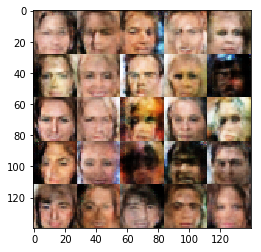

Epoch 1/1... Discriminator Loss: 1.2283... Generator Loss: 0.9412
Epoch 1/1... Discriminator Loss: 1.5608... Generator Loss: 0.4600
Epoch 1/1... Discriminator Loss: 1.2070... Generator Loss: 1.4712
Epoch 1/1... Discriminator Loss: 1.1861... Generator Loss: 1.0239
Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 1.2647
Epoch 1/1... Discriminator Loss: 1.1340... Generator Loss: 0.9463
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 1.0872
Epoch 1/1... Discriminator Loss: 1.2341... Generator Loss: 0.9763
Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.9995
Epoch 1/1... Discriminator Loss: 1.2693... Generator Loss: 0.7651


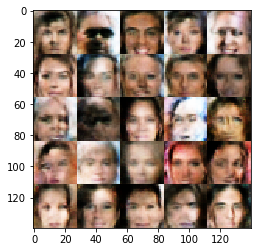

Epoch 1/1... Discriminator Loss: 1.2597... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 1.4406
Epoch 1/1... Discriminator Loss: 1.2648... Generator Loss: 0.7546
Epoch 1/1... Discriminator Loss: 1.0736... Generator Loss: 1.3106
Epoch 1/1... Discriminator Loss: 1.1919... Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 0.8274
Epoch 1/1... Discriminator Loss: 1.1693... Generator Loss: 1.0019
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.5937
Epoch 1/1... Discriminator Loss: 1.5557... Generator Loss: 1.6739
Epoch 1/1... Discriminator Loss: 1.1340... Generator Loss: 1.1748


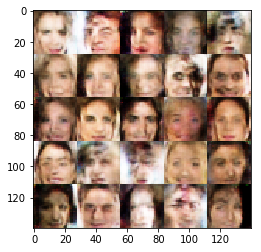

Epoch 1/1... Discriminator Loss: 1.2360... Generator Loss: 1.0500
Epoch 1/1... Discriminator Loss: 1.2338... Generator Loss: 0.8471
Epoch 1/1... Discriminator Loss: 1.1831... Generator Loss: 1.1389
Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 1.1294
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 1.2945
Epoch 1/1... Discriminator Loss: 1.1744... Generator Loss: 1.0300
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 1.2951... Generator Loss: 0.7683
Epoch 1/1... Discriminator Loss: 1.3067... Generator Loss: 0.9621
Epoch 1/1... Discriminator Loss: 1.2085... Generator Loss: 0.8067


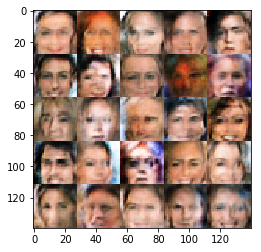

Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 0.9720
Epoch 1/1... Discriminator Loss: 1.4786... Generator Loss: 0.5148
Epoch 1/1... Discriminator Loss: 1.2225... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 1.3154... Generator Loss: 0.7641
Epoch 1/1... Discriminator Loss: 1.2732... Generator Loss: 1.0825
Epoch 1/1... Discriminator Loss: 1.2187... Generator Loss: 1.2730
Epoch 1/1... Discriminator Loss: 1.2349... Generator Loss: 0.9393
Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 1.6055
Epoch 1/1... Discriminator Loss: 1.2597... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.1833... Generator Loss: 1.0674


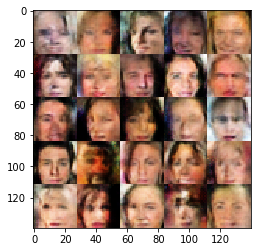

Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.4925
Epoch 1/1... Discriminator Loss: 1.1953... Generator Loss: 1.1416
Epoch 1/1... Discriminator Loss: 1.2105... Generator Loss: 1.0331
Epoch 1/1... Discriminator Loss: 1.1670... Generator Loss: 1.3102
Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 1.1568
Epoch 1/1... Discriminator Loss: 1.2973... Generator Loss: 1.3609
Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 1.0183
Epoch 1/1... Discriminator Loss: 1.2480... Generator Loss: 1.4441
Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 1.1663... Generator Loss: 1.3343


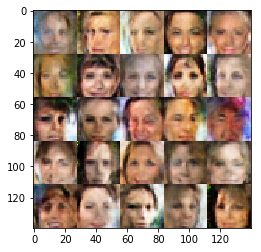

Epoch 1/1... Discriminator Loss: 1.1707... Generator Loss: 0.9354
Epoch 1/1... Discriminator Loss: 1.2582... Generator Loss: 1.1789
Epoch 1/1... Discriminator Loss: 1.2604... Generator Loss: 0.8737
Epoch 1/1... Discriminator Loss: 1.1523... Generator Loss: 1.0541
Epoch 1/1... Discriminator Loss: 1.2454... Generator Loss: 1.0309
Epoch 1/1... Discriminator Loss: 1.3294... Generator Loss: 1.3083
Epoch 1/1... Discriminator Loss: 1.1811... Generator Loss: 0.9932
Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 0.8111
Epoch 1/1... Discriminator Loss: 1.2365... Generator Loss: 0.8989
Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 1.1360


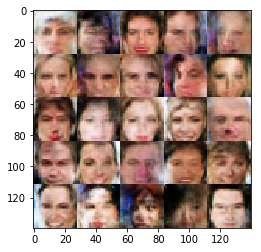

Epoch 1/1... Discriminator Loss: 1.2450... Generator Loss: 0.9833
Epoch 1/1... Discriminator Loss: 1.2410... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.5371
Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 0.9509
Epoch 1/1... Discriminator Loss: 1.1857... Generator Loss: 0.9085
Epoch 1/1... Discriminator Loss: 1.1857... Generator Loss: 1.1154
Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 0.8667
Epoch 1/1... Discriminator Loss: 1.2262... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 0.9143


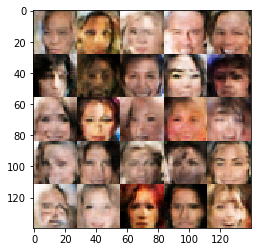

Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 1.6569
Epoch 1/1... Discriminator Loss: 1.1830... Generator Loss: 0.8721
Epoch 1/1... Discriminator Loss: 1.1986... Generator Loss: 0.8601
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 1.2303
Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 0.8341
Epoch 1/1... Discriminator Loss: 1.1310... Generator Loss: 0.9904
Epoch 1/1... Discriminator Loss: 1.2118... Generator Loss: 1.0477
Epoch 1/1... Discriminator Loss: 1.2415... Generator Loss: 0.6724
Epoch 1/1... Discriminator Loss: 1.2933... Generator Loss: 0.9779
Epoch 1/1... Discriminator Loss: 1.2261... Generator Loss: 0.8578


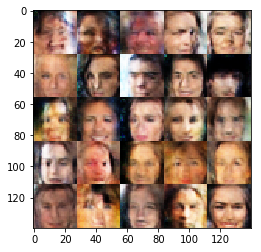

Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 1.7060
Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.1799... Generator Loss: 0.9570
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 1.1597
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 1.3777
Epoch 1/1... Discriminator Loss: 1.0738... Generator Loss: 1.0076
Epoch 1/1... Discriminator Loss: 1.2358... Generator Loss: 1.1070
Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.6534
Epoch 1/1... Discriminator Loss: 1.1511... Generator Loss: 0.9096
Epoch 1/1... Discriminator Loss: 1.2769... Generator Loss: 1.3206


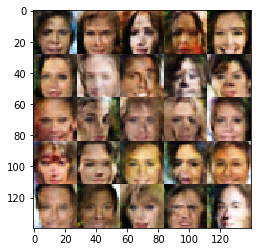

Epoch 1/1... Discriminator Loss: 1.0825... Generator Loss: 1.2863
Epoch 1/1... Discriminator Loss: 1.1726... Generator Loss: 0.9095
Epoch 1/1... Discriminator Loss: 1.2705... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 1.2073... Generator Loss: 1.3816
Epoch 1/1... Discriminator Loss: 1.1958... Generator Loss: 0.8480
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 1.5085


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.